In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from brian2 import us, ms, second, nA, pA, amp
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.plotting import plot_input_layer_with_membrane_potential, plot_reservoir_raster, plot_currents_distributions

In [2]:
np.random.seed(42)

# Stimulus

The conversion of I/Q-data into spike trains is done via an AsynchronousDeltaModulator, which converts a 2-dimensional vector of I and Q samples into spikes in 4 channels: I.up, I.dn, Q.up and Q.dn. The modulator essentially consists of two trailing thresholds, one for the up channel and one for the down channel. Each time the signal crosses either one of the thresholds a spike is generated in the correspoding channel.

The I and Q components are sampled at a rate which might not be high enough to get spike trains with a useful temporal resolution. It is therefore necessary to interpolate the I and Q components and to resample them at a higher frequency. 

The thresholds and the resampling rate thus define the minimal inter-spike interval and the maximal firing rate. (TODO: add some formal derivation)

Ideally these parameters should be set such that enough spikes are generated for the minimal change in amplitude of the I and Q components between two different baseband symbols that needs to be detected.

The input stimulus below was obtained by sending the string `neuro` through a radio channel with `8PSK` modulation. In this case the minimal change that we wish to detect is the one in the Q component between the first two baseband symbols.

## Spiking Radio Channel

## Concatenated input

## RadioML

In [3]:
from utils.dataset import load_dataset
from utils.plotting import plot_sample

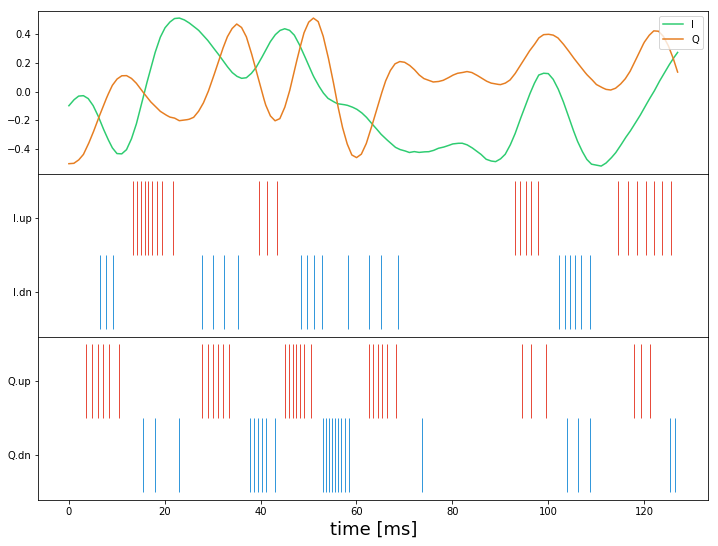

In [4]:
settings = {
    'snr': 18,
    'scale': 50,
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 200,
    'stretch_factor': 1000,
    'stop_after': 10000,
    'stop_neuron': 4
}
dataset, _ = load_dataset('./data/radioML/RML2016.10a_dict.pkl', snr=settings['snr'], scale=settings['scale'], normalize=False)
time_sample = np.arange(128)
sample = dataset[('QPSK', settings['snr'])][12]
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], time_sample, sample, \
                                             resampling_factor=settings['resampling_factor'], stretch_factor=settings['stretch_factor'])
plot_sample(signal, time_stim*us, indices, times*us, figsize=(12, 9))

In [5]:
bins = np.linspace(np.min(time_stim), np.max(time_stim), num=int(len(time_sample)/10)+1)

In [6]:
stop = round(bins[-1], ndigits=0)+settings['stop_after']
indices = np.append(indices, settings['stop_neuron'])
times = np.append(times, stop)*us

In [7]:
bins = bins*us

In [8]:
duration = 2*stop*us

# DPI Neuron and Synapse

We need to adapt the neuron and synapse time constants to the relevant time scales of the input. With an average time length of about 1ms for a baseband symbol, the DPI neuron should be able to generate spikes in half of this time interval.

## Input layer

The 4 spike generators are connected 1-to-1 to 4 input neurons. These neurons then project the input to 4 different subsets of reservoir neurons. The input neurons should have an integration time shorter than the average baseband symbol time length, in order to produce enough spike per symbol.

## Reservoir layer

The DPI neurons and synapsis in the reservoir layer should produce non-linear dynamics and thus have rather heterogenous properties. We therefore initialize them randomly by drawing from a uniform distribution.

In [9]:
from spiking_radio_reservoir import setup_hennequin_connectivity, setup_generator, setup_input_layer, setup_reservoir_layer, init_network
from utils.reservoir import getTauCurrent, getAhpTauCurrent
from brian2 import defaultclock

In [10]:
import joblib

In [11]:
params = {
    'wGen': 500,
    'wInp': 700,
    'pIR': 0.07,
    'pE_local': 0.5,
    'pI_local': 1.0,
    'k': 3,
    'DoC': 0.2,
    'loc_wResE': 120,
    'scale_wResE': 20,
    'loc_wResI': -250,
    'scale_wResI': 40,
    'Ninp': 4,
    'N': 800,
    'Ngx': 20,
    'Ngy': 20
}

In [12]:
connectivity = setup_hennequin_connectivity(params['N'], params['pIR'], params['Ngx'], params['Ngy'], \
    params['pE_local'], params['pI_local'], params['k'], params['DoC'], \
    params['loc_wResE'], params['scale_wResE'], params['loc_wResI'], params['scale_wResI'])
with open("./connectivity-hennequin-direct.joblib", "wb") as fo:
    joblib.dump(connectivity, fo)

100%|██████████| 800/800 [02:19<00:00,  5.29it/s]


In [13]:
input_neurons_Iup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==0]
input_neurons_Idn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==1]
input_neurons_Qup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==2]
input_neurons_Qdn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==3]
print("Input neurons:")
print("\t - I.up: {}".format(input_neurons_Iup))
print("\t - I.dn: {}".format(input_neurons_Idn))
print("\t - Q.up: {}".format(input_neurons_Qup))
print("\t - Q.dn: {}".format(input_neurons_Qdn))

Input neurons:
	 - I.up: [208  74 100 372 308 389 207 276  23  15 349 346 233 267]
	 - I.dn: [648 592 413 551 552 553 754 748 785 408 585 526 474 790]
	 - Q.up: [340  93 191 337  14  47 154  39  26 148  71 290 155 310]
	 - Q.dn: [432 436 574 463 782 738 624 550 720 682 755 671 510 778]


In [14]:
params['currents'] = {
    'gRes': {
        'Iahp': 0.5*pA,
        'Itauahp': getAhpTauCurrent(10*ms),
        'Itau': getTauCurrent(20*ms),
        'Ispkthr': 0.2*nA
    },
    'sInpRes': {
        'Ie_tau': getTauCurrent(5*ms)
    },
    'sResRes': {
        'Ie_tau': getTauCurrent(7*ms), 
        'Ii_tau': getTauCurrent(7*ms) 
    }
}
params['mismatch'] = {
    'gRes': {
        'Itau': 0.1,
        'Ispkthr': 0.2
    },
    'sResRes': {
        'Ie_tau': 0.1,
        'Ii_tau': 0.1,
    }
}

In [15]:
components = {'generator': None, 'layers': {}, 'synapses': {}, 'monitors': {}}
components = setup_generator(components)
components = setup_reservoir_layer(components, connectivity, params['mismatch'], params['N'], params['currents'], params['wInp'], direct_input=True)

In [16]:
network = init_network(components, indices, times)
defaultclock.dt = 50*us
network.run(duration)

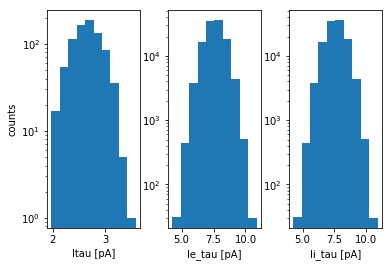

In [17]:
plot_currents_distributions(network)

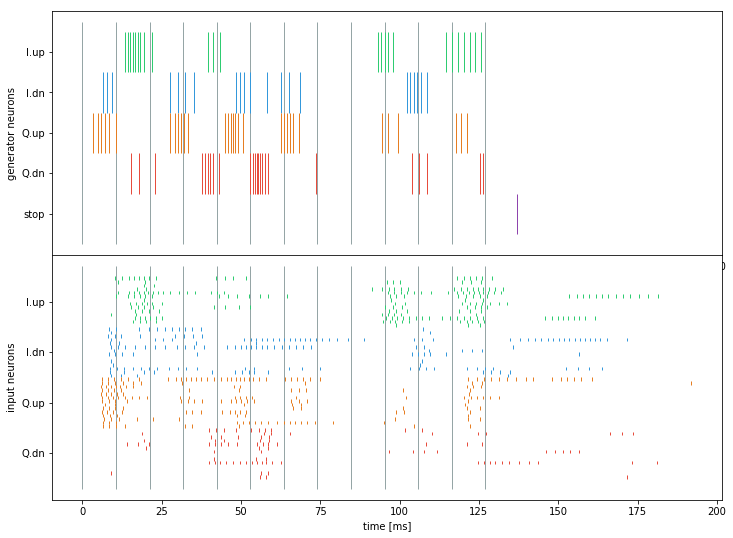

In [18]:
fig = plt.figure(figsize=(12, 9))
grid = grs.GridSpec(2, 1, wspace=0.0, hspace=0.0)
ax1 = plt.Subplot(fig, grid[0])
ax1.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5])
ax1.set_yticklabels(['stop', 'Q.dn', 'Q.up', 'I.dn', 'I.up'])
ax1.set_ylabel("generator neurons")
ax1.vlines(network['mGen'].t[network['mGen'].i==0]/ms, ymin=3.0, ymax=4.0, colors='#2ecc71', linewidth=1)
ax1.vlines(network['mGen'].t[network['mGen'].i==1]/ms, ymin=2.0, ymax=3.0, colors='#3498db', linewidth=1)
ax1.vlines(network['mGen'].t[network['mGen'].i==2]/ms, ymin=1.0, ymax=2.0, colors='#e67e22', linewidth=1)
ax1.vlines(network['mGen'].t[network['mGen'].i==3]/ms, ymin=0.0, ymax=1.0, colors='#e74c3c', linewidth=1)
ax1.vlines(network['mGen'].t[network['mGen'].i==4]/ms, ymin=-1.0, ymax=0.0, colors='#8e44ad', linewidth=1)
ax1.vlines(bins/ms, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], colors="#95a5a6", linewidth=1, zorder=0)
ax2 = plt.Subplot(fig, grid[1], sharex=ax1)
ax2.set_ylabel("input neurons")
num_inputs = len(input_neurons_Iup)
ax2.set_yticks([i*num_inputs+num_inputs/2 for i in range(4)])
ax2.set_yticklabels(['Q.dn', 'Q.up', 'I.dn', 'I.up'])
for (i, n) in enumerate(input_neurons_Iup):
    ax2.vlines(network['mRes'].t[network['mRes'].i==n]/ms, ymin=3.0*num_inputs+i, ymax=3.0*num_inputs+i+1, colors='#2ecc71', linewidth=1)
for (i, n) in enumerate(input_neurons_Idn):
    ax2.vlines(network['mRes'].t[network['mRes'].i==n]/ms, ymin=2.0*num_inputs+i, ymax=2.0*num_inputs+i+1, colors='#3498db', linewidth=1)
for (i, n) in enumerate(input_neurons_Qup):
    ax2.vlines(network['mRes'].t[network['mRes'].i==n]/ms, ymin=1.0*num_inputs+i, ymax=1.0*num_inputs+i+1, colors='#e67e22', linewidth=1)
for (i, n) in enumerate(input_neurons_Qdn):
    ax2.vlines(network['mRes'].t[network['mRes'].i==n]/ms, ymin=i, ymax=i+1, colors='#e74c3c', linewidth=1)
ax2.vlines(bins/ms, ymin=ax2.get_ylim()[0], ymax=ax2.get_ylim()[1], colors="#95a5a6", linewidth=1, zorder=0)
ax2.set_xlabel("time [ms]")
fig.add_subplot(ax1)
fig.add_subplot(ax2)

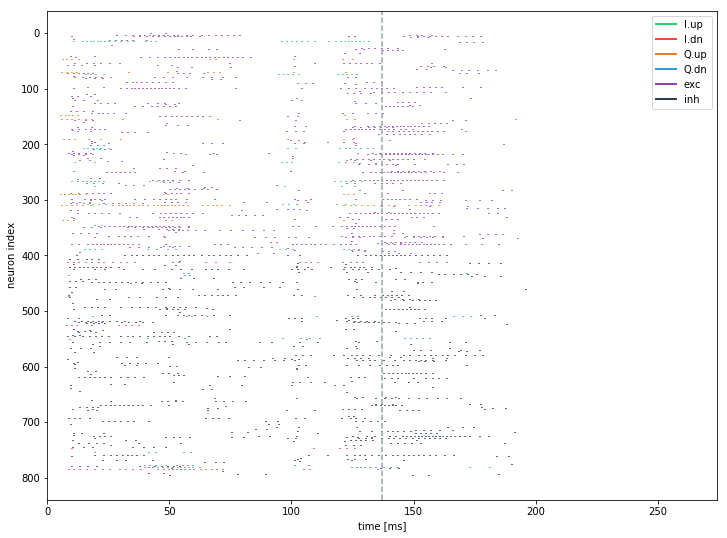

In [19]:
plot_reservoir_raster(connectivity, params, network, times, duration, figsize=(12, 9))